In [1]:
# x*h  = y; H·x = y --> solve linear equation(H|y)
# (1)Truncated SVD to H, (2)Truncated SVD to (H|y), (3)Truncated SVD to (H|y) + Tikhonov regularization
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
# import tensorflow as tf
# import tensorflow.keras as keras
import math
# from scipy.optimize import fsolve
# from scipy.optimize import root
from scipy.optimize import minimize
# from scipy import signal
from scipy import linalg
# import scipy as scp
# import sympy as  syp
# from tensorflow.keras import backend as K
# from tensorflow.keras.layers import Layer
# from tensorflow.keras.models import Sequential
import gc

In [2]:
class process_hyperspec(object):
    
    def __init__(self, path, scat):
        self.path = path
        self.scat = scat
        
    def read_data(self):
        ## Read data from txt
        data=pd.read_fwf(self.path, dtype = object, header = None)## Read data as Pandas DataFrame
        data_8 = data.loc[8,:].str[6:] ## Select data of column of wavelengths

        data_nm_dataframe =pd.read_csv(StringIO(data_8[0]))

        with open(self.path,'r',encoding='utf-8') as f:
            content = f.read()

        flag = 0
        for index in range(len(content)):##find the start point  of time and intensity data, pointer is the 'index'
            if (content[index] == '\n') and (flag != 9):
                flag = flag + 1
            elif (content[index] == '\n') and (flag == 9):
                break
            else:
                continue

        data_ns = pd.read_csv(StringIO(content[index:len(content)]), names = data_nm_dataframe.columns[0:len(set(data_nm_dataframe))]) ## Read data of time and gray 
        img_nm_ns = np.array(data_ns)    ## Transform to numpy array                                image as DataFrame; names is a 640x0 array indicates the wavelengths range
        
        self.data_frame = data_ns
        self.data_array = img_nm_ns
        
    def cal_846nm(self):
        time_total, wavelength_total = self.data_array.shape ## Generate an array contains intensity versus time data on 846nm
        data_846nm = np.zeros((time_total,), dtype = float )
        for i in range(wavelength_total):
            data_846nm = self.data_array[:,i] + data_846nm

        return data_846nm/wavelength_total
    
    def return_dataframe(self):
        
        return self.data_frame
    
    def return_array(self):
        return self.data_array

In [3]:
def name_g(i):
    if(i<=4 and i>=0):
        return  '0'+str(2*i+1)
    elif(i>4):
        return str(2*i+1)
    else:
        return None
    

dict1 = {i:'t5ns_scat'+ name_g(i) +'_abs_00.txt' for i in range(0, 8)}
dict1[-1] = 'ref_real_5ns.txt'


# print(dict1)

scat = [None]*9
data_480multi9 = np.zeros((9,480), dtype = float)
for i in range(0,9):
    scat[i] = process_hyperspec(dict1[i-1], i)
    scat[i].read_data()
    data_480multi9[i,:] = scat[i].cal_846nm()

time_index = scat[0].return_dataframe().index
# plt.figure('ns/nm')
# for i in range(0,9):
#     plt.plot(data_480multi9[i,:])
    
# plt.show()
del scat, dict1, name_g, process_hyperspec
gc.collect()

10

In [4]:
def smooth(y, box_pts):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth



def split_signal(y):
    THRESHOLD_V = 0.02
    for i in range(len(y)):
        if y[i] > THRESHOLD_V and y[i-1] <= THRESHOLD_V:
            index1  = i
        elif y[i] < THRESHOLD_V and y[i-1] >= THRESHOLD_V:
            index2 = i
    y2 = np.zeros((index2 - index1 + 1,))
    y2 = y[index1:index2]
        
    return y2, index1

#Generate h,y(x*h = y)
#===================================================================================================
data_intensity_extended = np.zeros((9, 959), dtype = float)
data_intensity_extended[:, 0:479]  = data_480multi9[:,0:479]
MAX = np.max(data_480multi9)
# h = smooth(data_480multi9[0,:]/max(data_480multi9[0,:]), 10) #x*h = y ; x.shape = (480,) h.shape = (480,) y.shape = (959,)
h = smooth(data_480multi9[0,:]/MAX, 10)

y =np.zeros((9,959))
for i in range(0,9):
    y[i,:] = smooth(data_intensity_extended[i,:]/MAX, 10)
    
#======================================================================================================

In [4]:
#(1)
#
# r0 = np.zeros((480,))
# r0[0] = h[0]
# A0 = linalg.toeplitz(h,r0)
# r1 = np.zeros((480,))
# r1[1:480] = h[::-1][0:479]
# A1 = np.triu(linalg.toeplitz(h,r1))
# A = np.vstack((A0, A1[0:479,]))

# U,d,VT = linalg.svd(A)
# M,N = A.shape
# Sig = linalg.diagsvd(d,M,N)
# # A_p = U.dot(Sig.dot(VT))

# # plt.plot(d)
# # plt.show()
# r = np.where(d>=0.005*max(d))

# U_p = U[:,r[0]]
# Sig_p_inv = linalg.diagsvd(1/d[r],len(r[0]),len(r[0]))
# VT_p = VT[r[0],:]
# # A_p = linalg.pinv(VT_p).dot(Sig_p_inv.dot(linalg.pinv(U_p)))

# A_p = linalg.pinv(VT_p).dot(Sig_p_inv.dot(linalg.pinv(U_p)))

# x_ = A_p.dot(y[i,:])

# plt.figure()
# # plt.axes(yscale = "log")
# plt.plot(x_)
# plt.show()

In [2]:
# (2)
#
def deconv(i, Threshold, h, y):
    # y =  x*h ; y = A·x A.shape = (M, N) M = len(x) + len(h) - 1 = len(y)
    M = len(y[i,:])
    N = len(h)
    r0 = np.zeros((N,))
    r0[0] = h[0]
    A0 = linalg.toeplitz(h,r0)
    r1 = np.zeros((N,))
    r1[1:N] = h[::-1][0:N-1]
    A1 = np.triu(linalg.toeplitz(h,r1))
    A = np.vstack((A0, A1[0:N-1,]))
    A = np.hstack((A, np.reshape(y[i,:], (M, 1))))

    U,d,VT = linalg.svd(A)
    a,b = A.shape
    Sig = linalg.diagsvd(d,a,b)
    # A_p = U.dot(Sig.dot(VT))

    # plt.plot(d)
    # plt.show()
    r = np.where(d>=Threshold*max(d))

    # U_p = U[0:len(h),r[0]]
    U_p = U[:,r[0]]
    Sig_p = linalg.diagsvd(d[r],len(r[0]),len(r[0]))
    VT_p = VT[r[0],:]

    A_p = U_p.dot(Sig_p.dot(VT_p))

    x_ = linalg.pinv(A_p[:,0:480]).dot(A_p[:,480])
    return x_, A_p

In [3]:
# (3)
#
def deconv(i, namda, Threshold, h, y):
    # y =  x*h ; y = A·x A.shape = (M, N) M = len(x) + len(h) - 1 = len(y)
    M = len(y[i,:])
    N = len(h)
    r0 = np.zeros((N,))
    r0[0] = h[0]
    A0 = linalg.toeplitz(h,r0)
    r1 = np.zeros((N,))
    r1[1:N] = h[::-1][0:N-1]
    A1 = np.triu(linalg.toeplitz(h,r1))
    A = np.vstack((A0, A1[0:N-1,]))
    A = np.hstack((A, np.reshape(y[i,:], (M, 1))))

    U,d,VT = linalg.svd(A)
    a,b = A.shape
    Sig = linalg.diagsvd(d,a,b)
    # A_p = U.dot(Sig.dot(VT))

    # plt.plot(d)
    # plt.show()
    r = np.where(d>=Threshold*max(d))

    # U_p = U[0:len(h),r[0]]
    U_p = U[:,r[0]]
    Sig_p = linalg.diagsvd(d[r],len(r[0]),len(r[0]))
    VT_p = VT[r[0],:]

    A_p = U_p.dot(Sig_p.dot(VT_p))
    # gamma_value = np.zeros((N,)) + 9.91
    # gamma_value[0:100,] = np.array(range(100,1000,9))*1e-2
    # gamma = np.diag(gamma_value)*namda
    gamma = np.diag([namda]*N)
    # x_ = linalg.pinv(A_p[:,0:480]).dot(A_p[:,480])
    x_ = linalg.inv(A_p[:,0:480].T.dot(A_p[:,0:480]) + gamma.T.dot(gamma)).dot(A_p[:,0:480].T).dot(A_p[:,480])
    return x_, A_p

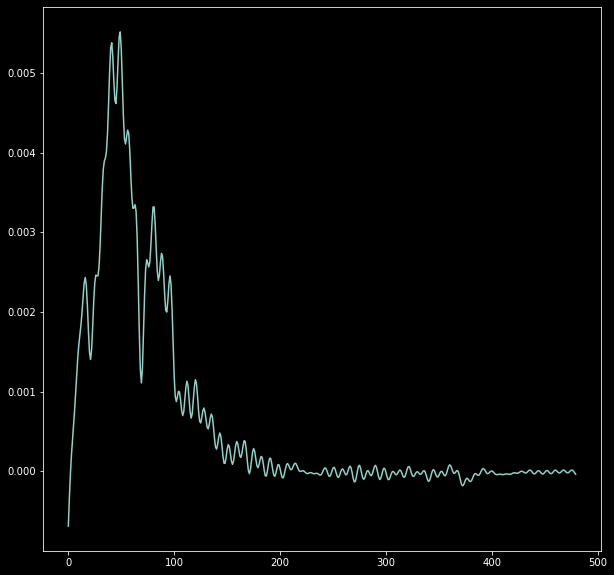

In [12]:
# # Compare the x_, h, y, y' = convolve(x_,h); x_*h + epsilon =  y
# # =====================================================================================================
# i = 1
# x_, _ = deconv(i, 1, 0.01, h, y)

# plt.figure(figsize = (10,10))
# plt.style.use('dark_background')
# line1, = plt.plot(x_/max(x_), color = 'red')
# line2, = plt.plot(h/max(h), color = 'green')
# line3, = plt.plot(y[i,:]/max(y[i,:]), color = 'orange', linestyle = '--')
# line4, = plt.plot(np.convolve(x_, h)/max(np.convolve(x_, h)), color = 'white', linestyle = '-.')
# plt.legend(handles=[line1,line2,line3,line4],labels=["x","IRF","y_standard","y_convolved"],loc="upper right",fontsize=15)
# plt.show()
# # ========================================================================================================================
# plot deconvolved x_ of 8 signals
# ========================================================================================
plt.figure(figsize = (10,10))
plt.style.use('dark_background')
for i in range(5, 6):
    x_, _ = deconv(i, 0.01, h, y)
    plt.plot(x_)

plt.show()
# =========================================================================================


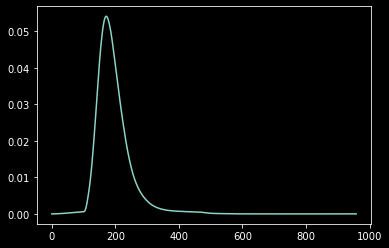

In [8]:
plt.plot(np.convolve(x_, h))
plt.show()